In [1]:
import os
import osr
import glob
import gdal
import numpy as np
import matplotlib.pyplot as plt
import datetime
import h5py
from netCDF4 import Dataset
import calendar
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
path_main = '/Users/binfang/Downloads/waterline_training'
path_modis_input = '/Users/binfang/Downloads/waterline_training/modis_input'
path_modis_output = '/Users/binfang/Downloads/waterline_training/modis_output'
path_model_input = '/Users/binfang/Downloads/waterline_training/model_input'
path_model_output = '/Users/binfang/Downloads/waterline_training/model_output'
path_smap = '/Users/binfang/Downloads/waterline_training/smap'

In [21]:
# 1. Process a single MODIS tile file

In [26]:
path_file = path_modis_input + '/myd11a1/MYD11A1.A2021305.h10v05.061.2021306220616.hdf'
hdf_ds = gdal.Open(path_file, gdal.GA_ReadOnly)

In [27]:
hdf_ds.GetSubDatasets()

[('HDF4_EOS:EOS_GRID:"/Users/binfang/Downloads/waterline_training/modis_input/myd11a1/MYD11A1.A2021305.h10v05.061.2021306220616.hdf":MODIS_Grid_Daily_1km_LST:LST_Day_1km',
  '[1200x1200] LST_Day_1km MODIS_Grid_Daily_1km_LST (16-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"/Users/binfang/Downloads/waterline_training/modis_input/myd11a1/MYD11A1.A2021305.h10v05.061.2021306220616.hdf":MODIS_Grid_Daily_1km_LST:QC_Day',
  '[1200x1200] QC_Day MODIS_Grid_Daily_1km_LST (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"/Users/binfang/Downloads/waterline_training/modis_input/myd11a1/MYD11A1.A2021305.h10v05.061.2021306220616.hdf":MODIS_Grid_Daily_1km_LST:Day_view_time',
  '[1200x1200] Day_view_time MODIS_Grid_Daily_1km_LST (8-bit unsigned integer)'),
 ('HDF4_EOS:EOS_GRID:"/Users/binfang/Downloads/waterline_training/modis_input/myd11a1/MYD11A1.A2021305.h10v05.061.2021306220616.hdf":MODIS_Grid_Daily_1km_LST:Day_view_angl',
  '[1200x1200] Day_view_angl MODIS_Grid_Daily_1km_LST (8-bit unsigned integ

In [28]:
# Loop read data of specified bands from subdataset_id
band_ds = gdal.Open(hdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly)
band_ds_arr = band_ds.ReadAsArray().astype(np.float32)
band_ds_arr = band_ds_arr * 0.02
band_ds_arr_qa = gdal.Open(hdf_ds.GetSubDatasets()[1][0], gdal.GA_ReadOnly)
band_ds_arr_qa = band_ds_arr_qa.ReadAsArray().astype(np.uint8)

In [29]:
band_ds.GetGeoTransform()

(-8895604.158132,
 926.6254331383334,
 0.0,
 4447802.079066,
 0.0,
 -926.6254331383334)

In [30]:
band_ds.GetProjection()

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [31]:
band_ds.GetMetadata()

{'add_offset_err': '0',
 'ALGORITHMPACKAGEACCEPTANCEDATE': '102004',
 'ALGORITHMPACKAGEMATURITYCODE': 'Normal',
 'ALGORITHMPACKAGENAME': 'MOD_PR11A',
 'ALGORITHMPACKAGEVERSION': '6',
 'ASSOCIATEDINSTRUMENTSHORTNAME.1': 'MODIS',
 'ASSOCIATEDPLATFORMSHORTNAME.1': 'Aqua',
 'ASSOCIATEDSENSORSHORTNAME.1': 'MODIS',
 'AUTOMATICQUALITYFLAG.1': 'Passed',
 'AUTOMATICQUALITYFLAGEXPLANATION.1': 'No automatic quality assessment is performed in the PGE.',
 'calibrated_nt': '5',
 'CLOUD_CONTAMINATED_LST_SCREENED': 'YES',
 'DAYNIGHTFLAG': 'Both',
 'DESCRREVISION': '6.1',
 'EASTBOUNDINGCOORDINATE': '-80.8406494782854',
 'EXCLUSIONGRINGFLAG.1': 'N',
 'GRINGPOINTLATITUDE.1': '39.9958333333333, 39.9958333333333, 30.0041666666667, 30.0041666666667',
 'GRINGPOINTLONGITUDE.1': '-104.438013067114, -91.3839615039452, -80.8406494782854, -92.388605818441',
 'GRINGPOINTSEQUENCENO.1': '1, 2, 3, 4',
 'HDFEOSVersion': 'HDFEOS_V2.19',
 'HORIZONTALTILENUMBER': '10',
 'identifier_product_doi': '10.5067/MODIS/MYD11A1.06

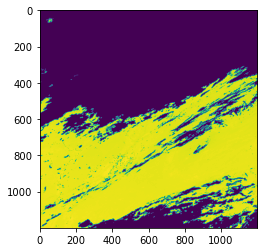

In [32]:
# Image before applying QA layer
plt.imshow(band_ds_arr)

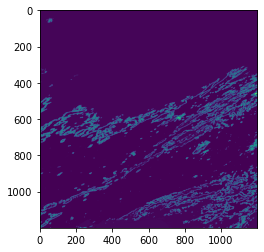

In [33]:
plt.imshow(band_ds_arr_qa)

In [34]:
# Convert the QA layer from decimal to binary
band_ds_arr_qa = band_ds_arr_qa.reshape(-1, 1)
band_ds_arr_qa_bin = [np.binary_repr(band_ds_arr_qa[x].item(), width=8) for x in range(len(band_ds_arr_qa))]
ind_qa = np.array([i for i in range(len(band_ds_arr_qa_bin)) if band_ds_arr_qa_bin[i][0] == '0'
                               and band_ds_arr_qa_bin[i][6] == '0'])

In [35]:
band_ds_arr_qa_mask = np.arange(band_ds_arr.shape[0]*band_ds_arr.shape[1])
band_ds_arr_qa_mask = np.isin(band_ds_arr_qa_mask, ind_qa).astype(int)
band_ds_arr_qa_mask = band_ds_arr_qa_mask.reshape(band_ds_arr.shape[0], band_ds_arr.shape[1])
band_ds_arr = band_ds_arr * band_ds_arr_qa_mask

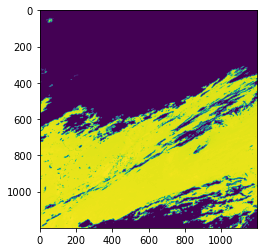

In [36]:
# Without filtered low quality pixels
plt.imshow(band_ds_arr)

In [37]:
# Write raster
out_ds = gdal.GetDriverByName('MEM').Create('', band_ds.RasterXSize, band_ds.RasterYSize, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(band_ds.GetGeoTransform())
out_ds.SetProjection(band_ds.GetProjection())

0

In [38]:
# Loop write each band to Geotiff file
for idb in range(1):
    out_ds.GetRasterBand(idb+1).WriteArray(band_ds_arr)
    out_ds.GetRasterBand(idb+1).SetNoDataValue(0)

In [39]:
# 2. Filter by QA layer, reproject and mosaic tiles of each day (Batch process)

In [3]:
# (Function 1) Extract data layers from MODIS HDF5 files, filter low quality pixels and write to GeoTiff
# (The function only works for MODIS LST and NDVI data sets!)

def hdf_subdataset_extraction(hdf_files, subdataset_id, band_n):

    # Open the dataset
    global band_ds
    hdf_ds = gdal.Open(hdf_files, gdal.GA_ReadOnly)

    # Loop read data of specified bands from subdataset_id
    size_1dim = gdal.Open(hdf_ds.GetSubDatasets()[0][0], gdal.GA_ReadOnly).ReadAsArray().astype(np.int16).shape
    band_array = np.empty([size_1dim[0], size_1dim[1], len(subdataset_id)//2])
    for idn in range(len(subdataset_id)//2):
        band_ds = gdal.Open(hdf_ds.GetSubDatasets()[subdataset_id[idn*2]][0], gdal.GA_ReadOnly)
        band_ds_arr = band_ds.ReadAsArray().astype(np.float32)
        band_ds_arr_qa = gdal.Open(hdf_ds.GetSubDatasets()[subdataset_id[idn*2+1]][0], gdal.GA_ReadOnly)

        # Find if the dataset is MODIS NDVI or MODIS LST
        if len(subdataset_id) > 2: # MODIS LST
            band_ds_arr = band_ds_arr * 0.02
            band_ds_arr_qa = band_ds_arr_qa.ReadAsArray().astype(np.uint8)
            band_ds_arr_qa = band_ds_arr_qa.reshape(-1, 1)
            band_ds_arr_qa_bin = [np.binary_repr(band_ds_arr_qa[x].item(), width=8) for x in range(len(band_ds_arr_qa))]
            ind_qa = np.array([i for i in range(len(band_ds_arr_qa_bin)) if band_ds_arr_qa_bin[i][0] == '0'
                               and band_ds_arr_qa_bin[i][6] == '0'])
        else: # MODIS NDVI
            band_ds_arr = band_ds_arr * 0.0001
            band_ds_arr_qa = band_ds_arr_qa.ReadAsArray().astype(np.uint16)
            band_ds_arr_qa = band_ds_arr_qa.reshape(-1, 1)
            band_ds_arr_qa_bin = [np.binary_repr(band_ds_arr_qa[x].item(), width=16) for x in range(len(band_ds_arr_qa))]
            ind_qa = np.array([i for i in range(len(band_ds_arr_qa_bin)) if band_ds_arr_qa_bin[i][-1] == '0'])

        band_ds_arr_qa_mask = np.arange(band_ds_arr.shape[0]*band_ds_arr.shape[1])
        band_ds_arr_qa_mask = np.isin(band_ds_arr_qa_mask, ind_qa).astype(int)
        band_ds_arr_qa_mask = band_ds_arr_qa_mask.reshape(band_ds_arr.shape[0], band_ds_arr.shape[1])
        band_ds_arr = band_ds_arr * band_ds_arr_qa_mask
        band_ds_arr[np.where(band_ds_arr <= 0)] = np.nan

        # Write into numpy array
        band_array[:, :, idn] = band_ds_arr
        del(band_ds_arr, band_ds_arr_qa, band_ds_arr_qa_bin, ind_qa, band_ds_arr_qa_mask)

    # Build output path
    # band_path = os.path.join(path_modis_op, os.path.basename(os.path.splitext(hdf_files)[0]) + "-ctd" + ".tif")
    # Write raster
    out_ds = gdal.GetDriverByName('MEM').Create('', band_ds.RasterXSize, band_ds.RasterYSize, band_n, #Number of bands
                                  gdal.GDT_Float32)
    out_ds.SetGeoTransform(band_ds.GetGeoTransform())
    out_ds.SetProjection(band_ds.GetProjection())

    # Loop write each band to Geotiff file
    for idb in range(len(subdataset_id)//2):
        out_ds.GetRasterBand(idb+1).WriteArray(band_array[:, :, idb])
        out_ds.GetRasterBand(idb+1).SetNoDataValue(0)
    # out_ds = None  #close dataset to write to disc

    return out_ds

In [4]:
# MODIS data layer information for extraction
# n^th of Layers to be extracted. The information of number of layers can be acquired by function GetSubDatasets()
subdataset_id_lst = [0, 1, 4, 5]  # For MODIS LST data: extract LST_Day_1km, QC_Day, LST_Night_1km, QC_Night
band_n_lst = 2  # For MODIS LST data: save LST_Day_1km, LST_Night_1km
subdataset_id_ndvi = [0, 2] # For MODIS NDVI data: extract NDVI, VI Quality
band_n_ndvi = 1 # For MODIS NDVI data: save NDVI
subdataset_id = [subdataset_id_lst, subdataset_id_ndvi]
band_n = [band_n_lst, band_n_ndvi]
modis_var_names = ['modis_lst_1km', 'modis_ndvi_1km']

# os.chdir(path_modis_input + '/myd11a1')
os.chdir(path_modis_input + '/myd13a2')
hdf_files = sorted(glob.glob('*.hdf'))

In [71]:
hdf_files

['MYD13A2.A2021297.h10v05.006.2021314015416.hdf',
 'MYD13A2.A2021297.h11v05.006.2021314015401.hdf',
 'MYD13A2.A2021297.h12v05.006.2021314015433.hdf']

In [72]:
# Sort and group the tile data by day
hdf_file_name = [hdf_files[x].split('.')[1] for x in range(len(hdf_files))]
hdf_file_name_unique = sorted(list(set(hdf_file_name)))

In [73]:
# Process and output the MODIS tile files
out_ds_list = []
for idt in range(len(hdf_file_name_unique)):
    hdf_files_toBuild_ind = [hdf_files.index(i) for i in hdf_files if hdf_file_name_unique[idt] in i]
    hdf_files_toBuild = [hdf_files[i] for i in hdf_files_toBuild_ind]

    hdf_files_list = []
    for idf in range(len(hdf_files_toBuild)):
#         extr_file = hdf_subdataset_extraction(path_modis_input + '/myd11a1/' + hdf_files_toBuild[idf], subdataset_id[0], band_n[0])
        extr_file = hdf_subdataset_extraction(path_modis_input + '/myd13a2/' + hdf_files_toBuild[idf], subdataset_id[1], band_n[0])
        hdf_files_list.append(extr_file)  # Append the processed hdf to the file list being merged
        print(hdf_files_toBuild[idf])  # Print the file being processed
        del(extr_file)
        
    # Open file and warp the target raster dimensions and geotransform (Output1)
    out_ds = gdal.Warp('', hdf_files_list, format='MEM', xRes=0.01, yRes=0.01,
                       dstSRS='EPSG:4326', warpOptions=['SKIP_NOSOURCE=YES'], errorThreshold=0,
                       resampleAlg=gdal.GRA_NearestNeighbour)
    out_ds_list.append(out_ds)
    del(out_ds)
    
    # Write to file (Output2)
#     out_ds_tofile = gdal.Warp(path_modis_output + '/myd11a1/' + modis_var_names[0] + '_' + hdf_file_name_unique[idt][1:] + '.tif',
#                                   hdf_files_list, xRes=0.01, yRes=0.01, dstSRS='EPSG:4326', warpOptions=['SKIP_NOSOURCE=YES'],
#                                   errorThreshold=0, resampleAlg=gdal.GRA_NearestNeighbour)
    out_ds_tofile = gdal.Warp(path_modis_output + '/myd13a2/' + modis_var_names[0] + '_' + hdf_file_name_unique[idt][1:] + '.tif',
                                  hdf_files_list, xRes=0.01, yRes=0.01, dstSRS='EPSG:4326', warpOptions=['SKIP_NOSOURCE=YES'],
                                  errorThreshold=0, resampleAlg=gdal.GRA_NearestNeighbour)
    out_ds_tofile = None


    print(path_modis_output + '/myd11a1/' + modis_var_names[0] + '_' + hdf_file_name_unique[idt][1:] + '.tif')
        

MYD13A2.A2021297.h10v05.006.2021314015416.hdf
MYD13A2.A2021297.h11v05.006.2021314015401.hdf
MYD13A2.A2021297.h12v05.006.2021314015433.hdf
/Users/binfang/Downloads/waterline_training/modis_output/myd11a1/modis_lst_1km_2021297.tif


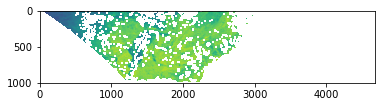

In [74]:
mat = out_ds_list[0].ReadAsArray()[0, :, :]
mat[mat==0] = np.nan
plt.imshow(mat)

In [51]:
# 3. Visualize the processed MODIS data

In [5]:
import matplotlib.ticker as mticker
import fiona
import rasterio
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [53]:
# Define extent
cellsize = out_ds_list[0].GetGeoTransform()[1]
size = [out_ds_list[0].RasterYSize, out_ds_list[0].RasterXSize]
lat_max = out_ds_list[0].GetGeoTransform()[3] - cellsize/2
lon_min = out_ds_list[0].GetGeoTransform()[0] - cellsize/2
lat_min = lat_max - cellsize*(size[0]-1)
lon_max = lon_min + cellsize*(size[1]-1)

lat_1km = np.linspace(lat_max, lat_min, size[0])
lon_1km = np.linspace(lon_min, lon_max, size[1])

path_gis_data = '/Users/binfang/Documents/SMAP_Project/data/gis_data'

In [56]:
mat_stack_lstd = []
mat_stack_lstn = []
for i in range(2):
    mat_d = out_ds_list[i].ReadAsArray()[0, :, :]
    mat_d[mat_d==0] = np.nan
    mat_n = out_ds_list[i].ReadAsArray()[1, :, :]
    mat_n[mat_n==0] = np.nan
    mat_stack_lstd.append(mat_d)
    mat_stack_lstn.append(mat_n)
    del(mat_d, mat_n)

In [57]:
xx, yy = np.meshgrid(lon_1km, lat_1km) # Create the map matrix
shape_file = ShapelyFeature(Reader(path_gis_data + '/cb_2015_us_state_500k/cb_2015_us_state_500k.shp').geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor='none')

Text(0.5, 0.96, 'MODIS LST (Day)')

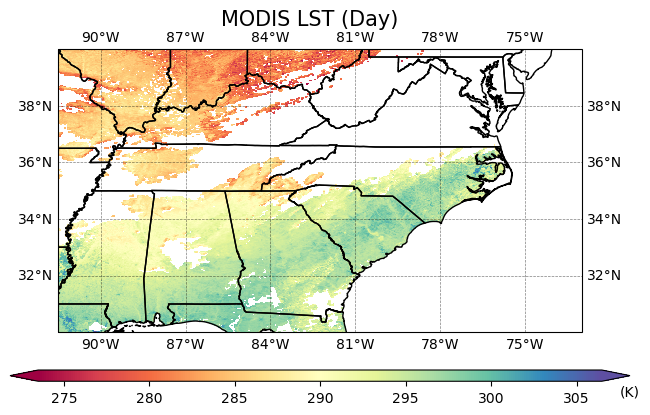

In [58]:
# Single LST map
fig = plt.figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-91.5, -73, 30, 40], ccrs.PlateCarree())
ax.add_feature(shape_file)
img = ax.pcolormesh(xx, yy, mat_stack_lstd[1], transform=ccrs.PlateCarree(), cmap='Spectral')
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5, color='black')
gl.xlocator = mticker.MultipleLocator(base=3)
gl.ylocator = mticker.MultipleLocator(base=2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cbar = plt.colorbar(img, extend='both', orientation='horizontal', aspect=50, pad=0.1)
cbar.set_label('(K)', fontsize=10, x=1, y=0.05, labelpad=-15)
plt.suptitle('MODIS LST (Day)', y=0.96, fontsize=15)


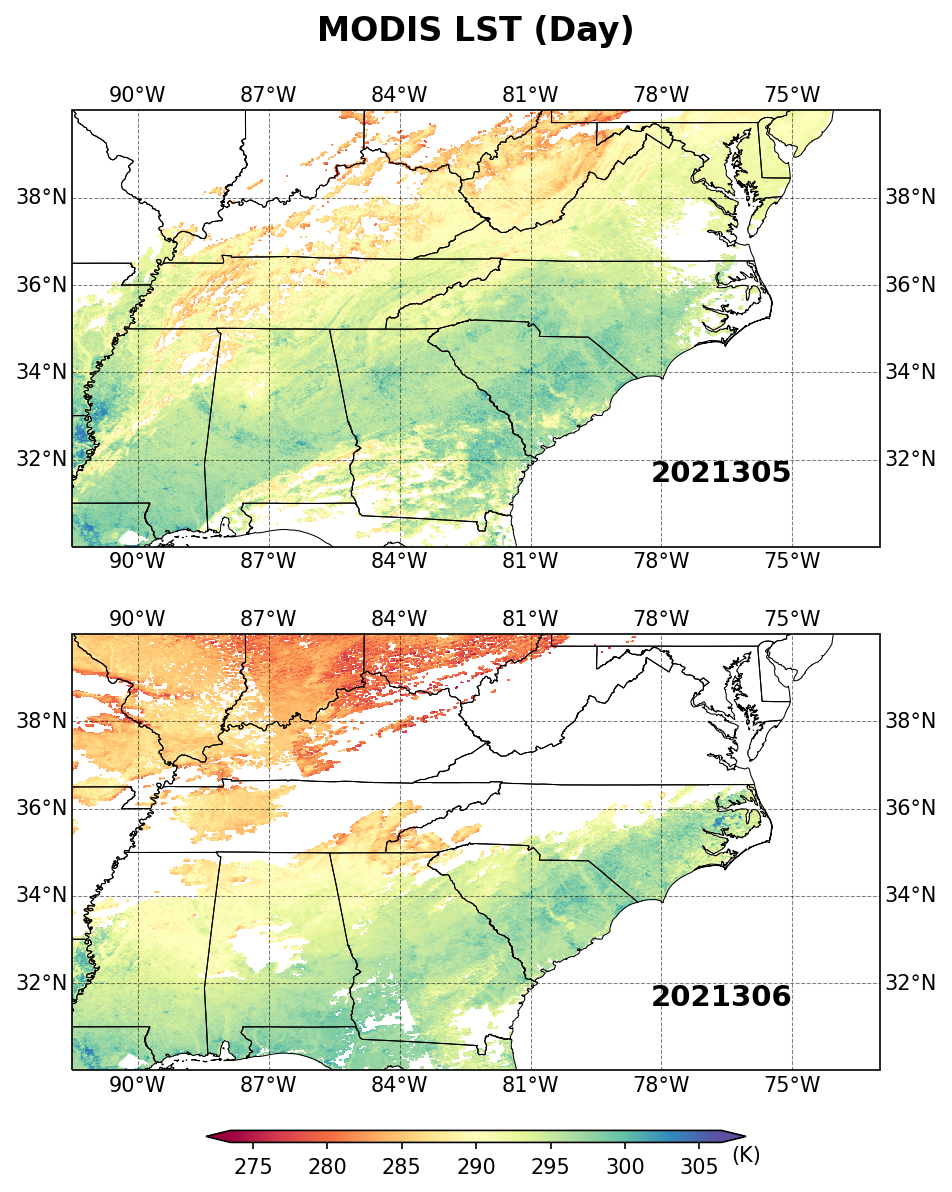

In [68]:
# Multple maps of LST data
fig = plt.figure(figsize=(6, 8), facecolor='w', edgecolor='k', dpi=150)
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace=0.2, wspace=0.2)
for ipt in range(2):
    ax = fig.add_subplot(2, 1, ipt+1, projection=ccrs.PlateCarree())
    ax.add_feature(shape_file, linewidth=0.5)
    ax.set_extent([-91.5, -73, 30, 40], ccrs.PlateCarree())
    img = ax.pcolormesh(xx, yy, mat_stack_lstd[ipt], transform=ccrs.PlateCarree(), cmap='Spectral')
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5, color='black')
    gl.xlocator = mticker.MultipleLocator(base=3)
    gl.ylocator = mticker.MultipleLocator(base=2)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # plt.colorbar(img, extend='both', orientation='horizontal', aspect=50, pad=0.1)
    # ax.set_title(title_content[ipt], pad=20, fontsize=14, weight='bold')
    ax.text(-75, 32, hdf_file_name_unique[ipt][1:], fontsize=14, horizontalalignment='right', 
            verticalalignment='top', weight='bold')
cbar_ax = fig.add_axes([0.2, 0.04, 0.6, 0.01])
cbar = fig.colorbar(img, cax=cbar_ax, extend='both', pad=0.1, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)
cbar_ax.locator_params(nbins=8)
cbar.set_label('(K)', fontsize=10, x=1, y=0.05, labelpad=-15)
plt.suptitle('MODIS LST (Day)', fontsize=16, weight='bold')
plt.show()
# plt.savefig(path_output + '/modis_lst.png')
plt.close()

In [75]:
hdf_file_name_unique

['A2021297']

In [ ]:
# 4. Reproject MODIS data

In [6]:
import rasterio
import osr

In [7]:
dst_srs = osr.SpatialReference()
dst_srs.ImportFromEPSG(6933)  # EASE grid projection
dst_wkt = dst_srs.ExportToWkt()
gts = (-17367530.44516138, 1000.89502334956, 0, 7314540.79258289, 0, -1000.89502334956)

In [8]:
# Load in variables
path_code = '/Users/binfang/Documents/SMAP_Project/smap_codes'
os.chdir(path_code)
f = h5py.File("ds_parameters.hdf5", "r")
varname_list = ['lat_world_max', 'lat_world_min', 'lon_world_max', 'lon_world_min',
                'lat_world_ease_9km', 'lon_world_ease_9km', 'lat_world_ease_1km', 'lon_world_ease_1km',
                'lat_world_ease_25km', 'lon_world_ease_25km', 'lat_world_geo_1km', 'lon_world_geo_1km', 
                'row_world_ease_1km_from_geo_1km_ind', 'col_world_ease_1km_from_geo_1km_ind', 
                'col_world_ease_1km_from_9km_ind', 'row_world_ease_1km_from_9km_ind']

for x in range(len(varname_list)):
    var_obj = f[varname_list[x]][()]
    exec(varname_list[x] + '= var_obj')
f.close()

In [9]:
########################################################################################################################
# (Function 2) Subset the coordinates table of subset area

def coordtable_subset(lat_input, lon_input, lat_extent_max, lat_extent_min, lon_extent_max, lon_extent_min):
    lat_output = lat_input[np.where((lat_input <= lat_extent_max) & (lat_input >= lat_extent_min))]
    row_output_ind = np.squeeze(np.array(np.where((lat_input <= lat_extent_max) & (lat_input >= lat_extent_min))))
    lon_output = lon_input[np.where((lon_input <= lon_extent_max) & (lon_input >= lon_extent_min))]
    col_output_ind = np.squeeze(np.array(np.where((lon_input <= lon_extent_max) & (lon_input >= lon_extent_min))))

    return lat_output, row_output_ind, lon_output, col_output_ind

In [10]:
shp_sub_ds = rasterio.open(path_modis_output + '/myd11a1/modis_lst_1km_2021305.tif')
# shp_sub_ds.bounds
shp_sub_extent = list(shp_sub_ds.bounds)
lat_sub_max = shp_sub_extent[3]
lat_sub_min = shp_sub_extent[1]
lon_sub_max = shp_sub_extent[2]
lon_sub_min = shp_sub_extent[0]

In [11]:
[lat_1km_sub, row_sub_1km_ind, lon_1km_sub, col_sub_1km_ind] = \
    coordtable_subset(lat_world_geo_1km, lon_world_geo_1km,
                      shp_sub_extent[3], shp_sub_extent[1], shp_sub_extent[2], shp_sub_extent[0])

In [12]:
[lat_1km_ease_sub, row_sub_1km_ease_ind, lon_1km_ease_sub, col_sub_1km_ease_ind] = \
    coordtable_subset(lat_world_ease_1km, lon_world_ease_1km,
                      shp_sub_extent[3], shp_sub_extent[1], shp_sub_extent[2], shp_sub_extent[0])

In [13]:
[lat_9km_sub, row_sub_9km_ind, lon_9km_sub, col_sub_9km_ind] = \
    coordtable_subset(lat_world_ease_9km, lon_world_ease_9km,
                      shp_sub_extent[3], shp_sub_extent[1], shp_sub_extent[2], shp_sub_extent[0])

In [18]:
lat_9km_sub

array([39.99618077, 39.90457956, 39.81309872, 39.72173755, 39.63049535,
       39.5393714 , 39.44836503, 39.35747554, 39.26670226, 39.17604451,
       39.08550162, 38.99507292, 38.90475776, 38.81455548, 38.72446544,
       38.63448699, 38.5446195 , 38.45486232, 38.36521484, 38.27567643,
       38.18624647, 38.09692435, 38.00770945, 37.91860119, 37.82959895,
       37.74070215, 37.65191018, 37.56322248, 37.47463845, 37.38615753,
       37.29777913, 37.20950269, 37.12132765, 37.03325344, 36.94527952,
       36.85740533, 36.76963033, 36.68195397, 36.59437571, 36.50689502,
       36.41951137, 36.33222423, 36.24503307, 36.15793739, 36.07093666,
       35.98403037, 35.89721801, 35.81049908, 35.72387308, 35.63733951,
       35.55089787, 35.46454768, 35.37828845, 35.29211969, 35.20604093,
       35.12005169, 35.03415149, 34.94833987, 34.86261635, 34.77698048,
       34.69143179, 34.60596983, 34.52059415, 34.43530428, 34.35009978,
       34.26498022, 34.17994514, 34.0949941 , 34.01012668, 33.92

In [180]:
# MODIS LST
n_layers = 2
modis_mat_geo = np.empty([len(lat_world_geo_1km), len(lon_world_geo_1km)], dtype='float32')
modis_mat_geo[:] = np.nan
modis_mat_ease = np.empty([len(lat_world_ease_1km), len(lon_world_ease_1km), n_layers], dtype='float32')
modis_mat_ease[:] = np.nan

os.chdir(path_modis_output + '/myd11a1')
modis_files = sorted(glob.glob('*.tif'))
    
for ife in range(len(modis_files)):
    modis_files_read = rasterio.open(modis_files[ife]).read()
    modis_mat_geo_1day = np.copy(modis_mat_geo)

    modis_mat_ease_write = np.copy(modis_mat_ease)
    for idm in range(n_layers):
        modis_mat_geo_1day = np.copy(modis_mat_geo)
        modis_mat_geo_1day[row_sub_1km_ind[0]:row_sub_1km_ind[-1]+1, col_sub_1km_ind[0]:col_sub_1km_ind[-1]+1] = modis_files_read[idm, :, :]
        modis_mat_1day = np.copy(modis_mat_geo_1day)
        modis_mat_ease_1day = np.array([np.nanmean(modis_mat_1day[row_world_ease_1km_from_geo_1km_ind[x], :], axis=0) 
                  for x in range(len(lat_world_ease_1km))])
        modis_mat_ease_1day = np.array([np.nanmean(modis_mat_ease_1day[:, col_world_ease_1km_from_geo_1km_ind[y]], axis=1) 
                  for y in range(len(lon_world_ease_1km))])
        modis_mat_ease_1day = np.fliplr(np.rot90(modis_mat_ease_1day, 3))
        modis_mat_ease_write[:, :, idm] = modis_mat_ease_1day
        del(modis_mat_ease_1day, modis_mat_geo_1day, modis_mat_1day)
    
    # 1.4 Save the daily MODIS LST/NDVI data to Geotiff files
    # Build output path
    name_writefile = modis_files[ife]
    # os.chdir(path_modis_model + modis_folders[ifo] + subfolders[iyr])

    # Create a raster of EASE grid projection at 1 km resolution
    out_ds_tiff = gdal.GetDriverByName('GTiff').Create(
        path_model_input + '/myd11a1/' + name_writefile, len(lon_world_ease_1km), len(lat_world_ease_1km), 
        n_layers, gdal.GDT_Float32, ['COMPRESS=LZW', 'TILED=YES'])
    out_ds_tiff.SetGeoTransform(gts)
    out_ds_tiff.SetProjection(dst_wkt)

    # Loop write each band to Geotiff file
    for idl in range(n_layers):
        out_ds_tiff.GetRasterBand(idl + 1).WriteArray(modis_mat_ease_write[:, :, idl])
        out_ds_tiff.GetRasterBand(idl + 1).SetNoDataValue(0)
    out_ds_tiff = None  # close dataset to write to disc
    del(modis_mat_ease_write)
    print(name_writefile)
    

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


modis_lst_1km_2021305.tif
modis_lst_1km_2021306.tif


In [181]:
# MODIS NDVI
n_layers = 1
modis_mat_geo = np.empty([len(lat_world_geo_1km), len(lon_world_geo_1km)], dtype='float32')
modis_mat_geo[:] = np.nan
modis_mat_ease = np.empty([len(lat_world_ease_1km), len(lon_world_ease_1km), n_layers], dtype='float32')
modis_mat_ease[:] = np.nan

os.chdir(path_modis_output + '/myd13a2')
modis_files = sorted(glob.glob('*.tif'))
    
for ife in range(len(modis_files)):
    modis_files_read = rasterio.open(modis_files[ife]).read()
    modis_mat_geo_1day = np.copy(modis_mat_geo)

    modis_mat_ease_write = np.copy(modis_mat_ease)
    for idm in range(n_layers):
        modis_mat_geo_1day = np.copy(modis_mat_geo)
        modis_mat_geo_1day[row_sub_1km_ind[0]:row_sub_1km_ind[-1]+1, col_sub_1km_ind[0]:col_sub_1km_ind[-1]+1] = modis_files_read[idm, :, :]
        modis_mat_1day = np.copy(modis_mat_geo_1day)
        modis_mat_ease_1day = np.array([np.nanmean(modis_mat_1day[row_world_ease_1km_from_geo_1km_ind[x], :], axis=0) 
                  for x in range(len(lat_world_ease_1km))])
        modis_mat_ease_1day = np.array([np.nanmean(modis_mat_ease_1day[:, col_world_ease_1km_from_geo_1km_ind[y]], axis=1) 
                  for y in range(len(lon_world_ease_1km))])
        modis_mat_ease_1day = np.fliplr(np.rot90(modis_mat_ease_1day, 3))
        modis_mat_ease_write[:, :, idm] = modis_mat_ease_1day
        del(modis_mat_ease_1day, modis_mat_geo_1day, modis_mat_1day)
    
    # 1.4 Save the daily MODIS LST/NDVI data to Geotiff files
    # Build output path
    name_writefile = modis_files[ife]
    # os.chdir(path_modis_model + modis_folders[ifo] + subfolders[iyr])

    # Create a raster of EASE grid projection at 1 km resolution
    out_ds_tiff = gdal.GetDriverByName('GTiff').Create(
        path_model_input + '/myd13a2/' + name_writefile, len(lon_world_ease_1km), len(lat_world_ease_1km), 
        n_layers, gdal.GDT_Float32, ['COMPRESS=LZW', 'TILED=YES'])
    out_ds_tiff.SetGeoTransform(gts)
    out_ds_tiff.SetProjection(dst_wkt)

    # Loop write each band to Geotiff file
    for idl in range(n_layers):
        out_ds_tiff.GetRasterBand(idl + 1).WriteArray(modis_mat_ease_write[:, :, idl])
        out_ds_tiff.GetRasterBand(idl + 1).SetNoDataValue(0)
    out_ds_tiff = None  # close dataset to write to disc
    del(modis_mat_ease_write)
    print(name_writefile)

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


modis_lst_1km_2021297.tif


In [ ]:
# 5. Implement the VIS/IR downscaling model on MODIS LST difference to calculate 1 km soil moisture (GLDAS)

In [14]:
os.chdir(path_code)
f = h5py.File("ds_parameters.hdf5", "r")
varname_list = ['lat_world_max', 'lat_world_min', 'lon_world_max', 'lon_world_min',
                'lat_world_ease_9km', 'lon_world_ease_9km', 'lat_world_ease_1km', 'lon_world_ease_1km',
                'lat_world_ease_25km', 'lon_world_ease_25km', 'row_world_ease_1km_from_25km_ind',
                'col_world_ease_1km_from_25km_ind', 'row_world_ease_1km_from_9km_ind', 'col_world_ease_1km_from_9km_ind',
                'row_world_ease_9km_from_1km_ext33km_ind', 'col_world_ease_9km_from_1km_ext33km_ind',
                'row_world_ease_25km_from_1km_ext40km_ind', 'col_world_ease_25km_from_1km_ext40km_ind']

for x in range(len(varname_list)):
    var_obj = f[varname_list[x]][()]
    exec(varname_list[x] + '= var_obj')
    del(var_obj)
f.close()

In [15]:
os.chdir(path_main)
f = h5py.File("ds_model_coef.hdf5", "r")
varname_list = list(f.keys())
varname_list = varname_list[0:24] # Load in only monthly linear regression model coefficients
for x in range(len(varname_list)):
    var_obj = f[varname_list[x]][()]
    exec(varname_list[x] + '= var_obj')
    del(var_obj)
f.close()

In [16]:
# Convert the 1 km from 9 km/25 km match table files to 1-d linear
col_meshgrid_from_9km, row_meshgrid_from_9km = np.meshgrid(col_world_ease_1km_from_9km_ind, row_world_ease_1km_from_9km_ind)
col_meshgrid_from_9km = col_meshgrid_from_9km.reshape(1, -1)
row_meshgrid_from_9km = row_meshgrid_from_9km.reshape(1, -1)

col_meshgrid_from_25km, row_meshgrid_from_25km = np.meshgrid(col_world_ease_1km_from_25km_ind, row_world_ease_1km_from_25km_ind)
col_meshgrid_from_25km = col_meshgrid_from_25km.reshape(1, -1)
row_meshgrid_from_25km = row_meshgrid_from_25km.reshape(1, -1)

In [41]:
matsize_smap_sm_model_1day = [len(lat_world_ease_1km), len(lon_world_ease_1km)]
smap_sm_model_mat_init_1day = np.empty(matsize_smap_sm_model_1day, dtype='float32')
smap_sm_model_mat_init_1day[:] = np.nan
smap_sm_model_mat_init_1day_1dim = smap_sm_model_mat_init_1day.reshape(1, -1)

In [35]:
os.chdir(path_model_input + '/myd11a1')
modis_lst_files = sorted(glob.glob('*.tif'))
ds_lst = gdal.Open(modis_lst_files[0]).ReadAsArray()
ds_lst[ds_lst > 333] = np.nan
ds_lst[ds_lst < 213] = np.nan
ds_lst_am = ds_lst[1, :, :] - ds_lst[0, :, :]

In [36]:
ds_lst_am = ds_lst_am.reshape(1, -1)
ds_lst_am_ind = np.where(~np.isnan(ds_lst_am))[1]
ds_lst_am_nonnan = ds_lst_am[0, ds_lst_am_ind]

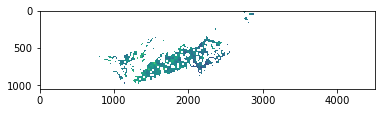

In [68]:
plt.imshow(smap_sm_1km_am_model[row_sub_1km_ease_ind[0]:row_sub_1km_ease_ind[-1]+1, col_sub_1km_ease_ind[0]:col_sub_1km_ease_ind[-1]+1])

In [32]:
os.chdir(path_model_input + '/myd13a2')
modis_ndvi_files = sorted(glob.glob('*.tif'))
ds_ndvi_idx = gdal.Open(modis_ndvi_files[0]).ReadAsArray()
ds_ndvi_idx = np.nan_to_num(ds_ndvi_idx)
ds_ndvi_idx = np.fix(ds_ndvi_idx*10).astype(int)
ds_ndvi_idx[np.where(ds_ndvi_idx >= 10)] = 9

In [33]:
# Extract coefficient and intercept from the position indices of corresponding monthly model file
ds_ndvi_idx = ds_ndvi_idx.reshape(1, -1)
month_id = '11'
exec('coef_mat_am = ' + 'coef_mat_am_' + month_id)
exec('coef_mat_pm = ' + 'coef_mat_pm_' + month_id)


In [55]:
# AM SM
coef_mat_am_coef = np.array([coef_mat_am[row_meshgrid_from_25km[0, ds_lst_am_ind[x]], col_meshgrid_from_25km[0, ds_lst_am_ind[x]],
                                                     ds_ndvi_idx[0, ds_lst_am_ind[x]]*2] for x in range(len(ds_lst_am_ind))])
coef_mat_am_intc = np.array([coef_mat_am[row_meshgrid_from_25km[0, ds_lst_am_ind[x]], col_meshgrid_from_25km[0, ds_lst_am_ind[x]],
                                                     ds_ndvi_idx[0, ds_lst_am_ind[x]]*2+1] for x in range(len(ds_lst_am_ind))])
smap_sm_1km_am_model_nonnan = coef_mat_am_coef * ds_lst_am_nonnan + coef_mat_am_intc
smap_sm_1km_am_model = np.copy(smap_sm_model_mat_init_1day_1dim)
smap_sm_1km_am_model[0, ds_lst_am_ind] = smap_sm_1km_am_model_nonnan
smap_sm_1km_am_model[np.where(smap_sm_1km_am_model <= 0)] = np.nan
smap_sm_1km_am_model = smap_sm_1km_am_model.reshape(matsize_smap_sm_model_1day)
smap_sm_1km_am_model = np.expand_dims(smap_sm_1km_am_model, axis=2)

In [57]:
# Save the daily MODIS LST/NDVI data to Geotiff files
# Build output path
name_sm_writefile = 'sm' + modis_lst_files[0][9:]
n_layers = 1

# Create a raster of EASE grid projection at 1 km resolution
out_ds_tiff = gdal.GetDriverByName('GTiff').Create(
    path_model_output + '/' + name_sm_writefile, len(lon_world_ease_1km), len(lat_world_ease_1km), 
    n_layers, gdal.GDT_Float32, ['COMPRESS=LZW', 'TILED=YES'])
out_ds_tiff.SetGeoTransform(gts)
out_ds_tiff.SetProjection(dst_wkt)

# Loop write each band to Geotiff file
for idl in range(n_layers):
    out_ds_tiff.GetRasterBand(idl + 1).WriteArray(smap_sm_1km_am_model[:, :, idl])
    out_ds_tiff.GetRasterBand(idl + 1).SetNoDataValue(0)
out_ds_tiff = None  # close dataset to write to disc
print(name_sm_writefile)

sm_1km_2021305.tif


In [62]:
# 6. Process SMAP enhanced L2 radiometer half-orbit SM 9 km data
matsize_smap_1day = [len(lat_world_ease_9km), len(lon_world_ease_9km), 2]
smap_mat_init_1day = np.empty(matsize_smap_1day, dtype='float32')
smap_mat_init_1day[:] = np.nan

In [60]:
os.chdir(path_smap + '/9km')
smap_files= sorted(glob.glob('*.h5'))

In [64]:
# Read swath files within a day and stack
smap_mat_1day = np.copy(smap_mat_init_1day)
for ife in range(len(smap_files)):
    smap_mat_1file = np.copy(smap_mat_init_1day)[:, :, 0]
    fe_smap = h5py.File(smap_files[ife], "r")
    group_list_smap = list(fe_smap.keys())
    smap_data_group = fe_smap[group_list_smap[1]]
    varname_list_smap = list(smap_data_group.keys())
    # Extract variables
    col_ind = smap_data_group[varname_list_smap[0]][()]
    row_ind = smap_data_group[varname_list_smap[1]][()]
    sm_flag = smap_data_group[varname_list_smap[15]][()]
    sm = smap_data_group[varname_list_smap[22]][()]
    sm[np.where(sm < 0)] = np.nan
    # sm[np.where(sm == -9999)] = np.nan
    # sm[np.where((sm_flag == 7) & (sm_flag == 15))] = np.nan # Refer to the results of np.binary_repr

    smap_mat_1file[row_ind, col_ind] = sm
    smap_mat_1day[:, :, ife] = smap_mat_1file
    print(smap_files[ife])
    fe_smap.close()

SMAP_L2_SM_P_E_36064_D_20211101T114253_R18290_001.h5
SMAP_L2_SM_P_E_36071_A_20211101T222254_R18290_001.h5


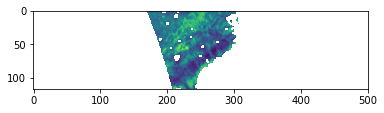

In [76]:
plt.imshow(smap_mat_1day[row_sub_9km_ind[0]:row_sub_9km_ind[-1]+1, col_sub_9km_ind[0]:col_sub_9km_ind[-1]+1, 1])

In [88]:
range(len(var_name))

range(0, 1)

In [93]:
# Save file
name_sm_9km_writefile = 'sm_9' + modis_lst_files[0][11:-3] + 'h5'
os.chdir(path_smap + '/9km_grided')
var_name = ['smap_sm_9km_am']
with h5py.File(name_sm_9km_writefile, 'w') as f:
    for idv in range(len(var_name)):
        f.create_dataset(var_name[idv], data=smap_mat_1day)
    f.close()
# del(smap_mat_month_am, smap_mat_month_pm)

In [89]:
# 7. Downscale the 1km soil moisture model output by 9 km SMAP L2 soil moisture data (GLDAS)

# Create initial EASE grid projection matrices
smap_sm_1km_agg_init = np.empty([len(lat_world_ease_9km), len(lon_world_ease_9km)], dtype='float32')
smap_sm_1km_agg_init[:] = np.nan
smap_sm_1km_disagg_init = np.empty([len(lat_world_ease_1km), len(lon_world_ease_1km)], dtype='float32')
smap_sm_1km_disagg_init = smap_sm_1km_disagg_init.reshape(1, -1)
smap_sm_1km_disagg_init[:] = np.nan
smap_sm_1km_ds_init = np.empty([len(lat_world_ease_1km), len(lon_world_ease_1km), 2], dtype='float32')
smap_sm_1km_ds_init[:] = np.nan

In [97]:
# Read 9 km SMAP SM
os.chdir(path_smap + '/9km_grided')
smap_files= sorted(glob.glob('*.h5'))
smap_sm_9km_name = ['smap_sm_9km']

f_smap_9km = h5py.File(smap_files[0], "r")
varname_list_smap_ip = list(f_smap_9km.keys())
for x in range(len(varname_list_smap_ip)):
    var_obj = f_smap_9km[varname_list_smap_ip[x]][()]
    exec(smap_sm_9km_name[x] + '= var_obj')
    del(var_obj)
f_smap_9km.close()

# smap_sm_9km = np.concatenate((smap_sm_9km_am, smap_sm_9km_pm), axis=2)
# del(smap_sm_9km_am, smap_sm_9km_pm)

In [113]:
# Read 1 km Theta-DeltaT Model SM
os.chdir(path_model_output)
modis_files = sorted(glob.glob('*.tif'))
modis_1km_sm_ds = rasterio.open(modis_files[0])
modis_1km_sm_mat = rasterio.open(modis_files[0]).read()
smap_sm_1km = np.transpose(modis_1km_sm_mat, (1, 2, 0))

In [105]:
smap_sm_1km.shape

(14616, 34704, 1)

In [127]:
n_layers = 1
smap_sm_1km_ds_output = np.copy(smap_sm_1km_ds_init)
for idf in range(n_layers):
    # Aggregate 1km SM model output to 9 km resolution, and calculate its difference with 9 km SMAP SM
    smap_sm_1km_agg = np.copy(smap_sm_1km_agg_init)

    smap_sm_1km_1file = smap_sm_1km[:, :, idf]
    smap_sm_1km_1file_1dim = smap_sm_1km_1file.reshape(1, -1)
    smap_sm_1km_1file_ind = np.where(~np.isnan(smap_sm_1km_1file_1dim))[1]

    smap_sm_1km_agg = np.array([np.nanmean(smap_sm_1km_1file[row_world_ease_9km_from_1km_ext33km_ind[x], :], axis=0) 
                                for x in range(len(lat_world_ease_9km))])
    smap_sm_1km_agg = np.array ([np.nanmean(smap_sm_1km_agg[:, col_world_ease_9km_from_1km_ext33km_ind[y]], axis=1) 
                                 for y in range(len(lon_world_ease_9km))])
    smap_sm_1km_agg = np.fliplr(np.rot90(smap_sm_1km_agg, 3))
    smap_sm_1km_delta = smap_sm_9km[:, :, idf] - smap_sm_1km_agg
    # smap_sm_1km_delta = smap_sm_1km_delta.reshape(1, -1)

    smap_sm_1km_delta_disagg = np.array(
        [smap_sm_1km_delta[row_meshgrid_from_9km[0, smap_sm_1km_1file_ind[x]], col_meshgrid_from_9km[0, smap_sm_1km_1file_ind[x]]] 
         for x in range(len(smap_sm_1km_1file_ind))])
    smap_sm_1km_disagg = np.copy(smap_sm_1km_disagg_init)
    smap_sm_1km_disagg[0, smap_sm_1km_1file_ind] = smap_sm_1km_delta_disagg
    smap_sm_1km_disagg = smap_sm_1km_disagg.reshape(len(lat_world_ease_1km), len(lon_world_ease_1km))
    smap_sm_1km_ds = smap_sm_1km_1file + smap_sm_1km_disagg
    smap_sm_1km_ds[np.where(smap_sm_1km_ds <= 0)] = np.nan
    smap_sm_1km_ds_output[:, :, idf] = smap_sm_1km_ds
    del(smap_sm_1km_agg, smap_sm_1km_1file, smap_sm_1km_1file_1dim, smap_sm_1km_1file_ind, smap_sm_1km_delta,
                            smap_sm_1km_delta_disagg, smap_sm_1km_disagg, smap_sm_1km_ds)

/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [131]:
smap_sm_1km_ds_output[smap_sm_1km_ds_output > 0.7] = np.nan
smap_sm_1km_ds_output[smap_sm_1km_ds_output < 0] = np.nan

In [135]:
np.nanmin(smap_sm_1km_ds_output)

0.07259542

In [128]:
smap_sm_1km_ds_output.shape

(14616, 34704, 2)

In [119]:
# smap_sm_1km_ds_output = smap_sm_1km_ds_output[:, :, 0]

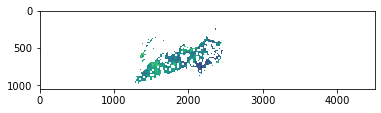

In [132]:
plt.imshow(smap_sm_1km_ds_output[row_sub_1km_ease_ind[0]:row_sub_1km_ease_ind[-1]+1, col_sub_1km_ease_ind[0]:col_sub_1km_ease_ind[-1]+1, 0])

In [121]:
# smap_sm_1km_ds_output = np.expand_dims(smap_sm_1km_ds_output, axis=2)

In [133]:
# Save the daily 1 km SM model output to Geotiff files
dst_srs = osr.SpatialReference()
dst_srs.ImportFromEPSG(6933)  # EASE grid projection
dst_wkt = dst_srs.ExportToWkt()
gts = (-17367530.44516138, 1000.89502334956, 0, 7314540.79258289, 0, -1000.89502334956)

os.chdir(path_smap + '/1km')
name_sm_1km_writefile = 'sm_1' + modis_lst_files[0][11:-3] + 'tif'

# Create a raster of EASE grid projection at 1 km resolution
out_ds_tiff = gdal.GetDriverByName('GTiff').Create(
    name_sm_1km_writefile, len(lon_world_ease_1km), len(lat_world_ease_1km), 1, gdal.GDT_Float32, ['COMPRESS=LZW', 'TILED=YES'])
out_ds_tiff.SetGeoTransform(gts)
out_ds_tiff.SetProjection(dst_wkt)

# Loop write each band to Geotiff file
for idf in range(n_layers):
    out_ds_tiff.GetRasterBand(idf + 1).WriteArray(smap_sm_1km_ds_output[:, :, idf])
    out_ds_tiff.GetRasterBand(idf + 1).SetNoDataValue(0)
out_ds_tiff = None  # close dataset to write to disc

print(name_sm_1km_writefile)
# del (smos_sm_1km_ds_output, ds_smos_sm_1km, out_ds_tiff)

sm_1km_2021305.tif


In [17]:
# 8. 1km/9km SMAP SM Visualization
import matplotlib.ticker as mticker
import fiona
import rasterio
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
path_gis_data = '/Users/binfang/Documents/SMAP_Project/data/gis_data'

In [24]:
shape_file = ShapelyFeature(Reader(path_gis_data + '/cb_2015_us_state_500k/cb_2015_us_state_500k.shp').geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor='none')

In [33]:
## Define map extent
# lat_sub_max = shp_sub_extent[3]
# lat_sub_min = shp_sub_extent[1]
# lon_sub_max = shp_sub_extent[2]
# lon_sub_min = shp_sub_extent[0]
map_extent = [39.69559, 30.49772, -73.64647, -84.34852]
[lat_1km_map, row_map_1km_ind, lon_1km_map, col_map_1km_ind] = \
    coordtable_subset(lat_world_ease_1km, lon_world_ease_1km,
                      map_extent[0], map_extent[1], map_extent[2], map_extent[3])
[lat_9km_map, row_map_9km_ind, lon_9km_map, col_map_9km_ind] = \
    coordtable_subset(lat_world_ease_9km, lon_world_ease_9km,
                      map_extent[0], map_extent[1], map_extent[2], map_extent[3])
xx, yy = np.meshgrid(lon_1km_map, lat_1km_map) 

In [22]:
os.chdir(path_smap + '/1km')
smap_1km_sm_files = sorted(glob.glob('*.tif'))
hdf_ds = gdal.Open(smap_1km_sm_files[0], gdal.GA_ReadOnly)
smap_1km_sm_mat = hdf_ds.ReadAsArray().astype(np.float32)

In [29]:
smap_1km_sm_mat.shape

(14616, 34704)

Text(0.5, 0.96, 'SMAP 1km')

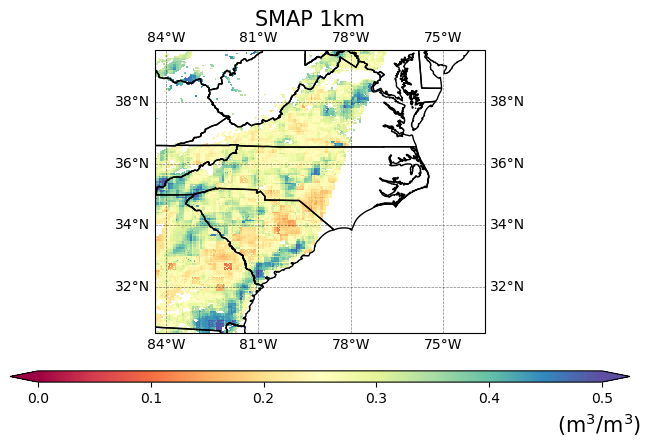

In [35]:
# Single SM map
fig = plt.figure(num=None, figsize=(8, 5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-91.5, -73, 30, 40], ccrs.PlateCarree())
ax.set_extent([map_extent[3], map_extent[2], map_extent[1], map_extent[0]], ccrs.PlateCarree())
ax.add_feature(shape_file)
img = ax.pcolormesh(xx, yy, smap_1km_sm_mat[row_map_1km_ind[0]:row_map_1km_ind[-1]+1, col_map_1km_ind[0]:col_map_1km_ind[-1]+1], 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap='Spectral')
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5, color='black')
gl.xlocator = mticker.MultipleLocator(base=3)
gl.ylocator = mticker.MultipleLocator(base=2)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cbar = plt.colorbar(img, extend='both', orientation='horizontal', aspect=50, pad=0.1)
cbar.set_label('$\mathregular{(m^3/m^3)}$', fontsize=15, x=0.95)
plt.suptitle('SMAP 1km SM', y=0.96, fontsize=15)